# Gender Recognition

Now that we have our differents datasets. We can start model searching. We have here a classification problem where we need to guess if the person talking is a male (0) or a female (1).

At first i will explore classic models with the same number of features : averageDataset, shortDataset, longDataset and shortLongDataset

In [24]:
#imports 
import os #file handling
import pandas as pd #data handling
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from time import time
from tqdm import tqdm #progress bar

#remove warnings
import warnings
warnings.filterwarnings('ignore')

#to save computer expensive variables
import pickle
import joblib

# Data exploration

In [25]:
#dataset imports
averageDataset = pd.read_csv('csv/averageDataset.csv')
shortDataset = pd.read_csv('csv/shortDataset.csv')
#longDataset = pd.read_csv('csv/longDataset.csv')
shortLongDataset = pd.read_csv('csv/shortLongDataset.csv')

In [26]:
averageDataset

,gender,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12
0,females,-261.33215,128.83803,-46.805300,34.379566,-33.132510,17.100864,-41.053497,6.145863,-24.269693,0.488125,0.892438,-12.252017,2.793226
1,females,-360.14386,134.22116,-46.355534,30.269516,-7.254152,-12.367200,-17.298020,-3.165615,-3.758249,3.102424,-6.868053,-1.620929,-1.403311
2,females,-286.69043,156.18822,-41.512173,31.948523,-10.561868,-19.949524,-10.126457,-3.679858,-21.546928,11.303806,-12.979272,-3.754963,4.856138
3,females,-299.98563,116.74078,-67.229370,46.647755,-34.803288,22.505386,-23.868324,5.574744,-3.069399,-1.333133,-1.351635,-0.398472,1.449610
4,females,-294.24106,125.60786,-12.183826,27.120895,-21.403048,19.212172,-37.408417,4.841165,-13.373237,-3.668624,-2.865604,-5.062353,-1.684518
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5988,males,-126.74551,140.25046,-83.679370,20.615292,-25.494814,-4.818202,-35.335598,-17.952202,-33.506810,-13.786844,-5.004233,-14.524476,-3.005208
5989,males,-326.32315,147.57486,-11.761257,41.416393,-19.820679,2.906410,-24.484390,0.479944,-13.231592,-7.734329,-3.179237,-9.954266,-1.893782
5990,males,-223.16524,160.09851,-12.671089,46.775265,-4.866661,9.460329,-7.376697,-2.501361,-9.317673,-1.430610,-4.600437,1.298727,4.792800
5991,males,-412.06850,146.96812,-25.503767,43.596836,-15.076727,-5.397608,-13.204176,-3.277591,-15.041212,-4.453312,-6.757757,-6.240677,1.557210


In [27]:
# show features distribution, after using this function, you can see the distribution of each feature of a dataset
def showFeatureDistribution(data):
    for feature in data.columns[1:]:
        plt.figure(figsize=(10, 6))
        sns.histplot(data[feature], kde=True)
        plt.title(f'{feature} distribution')
        plt.show()

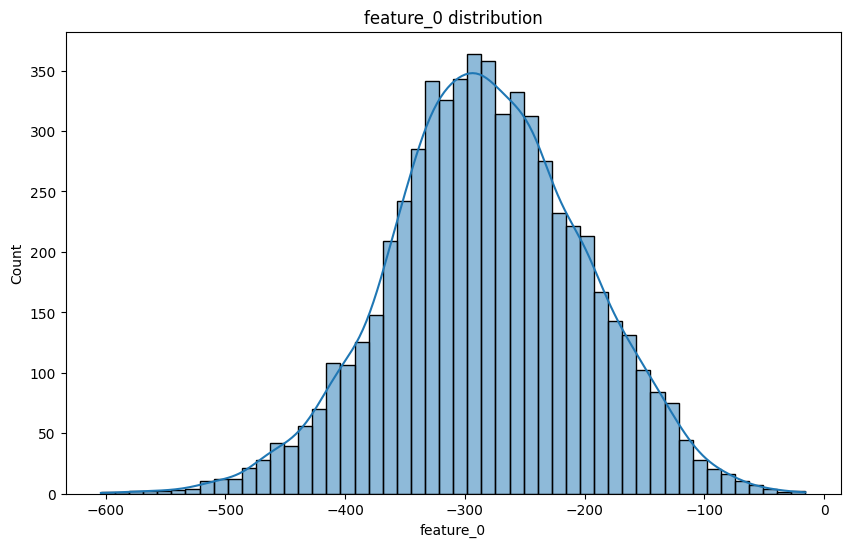

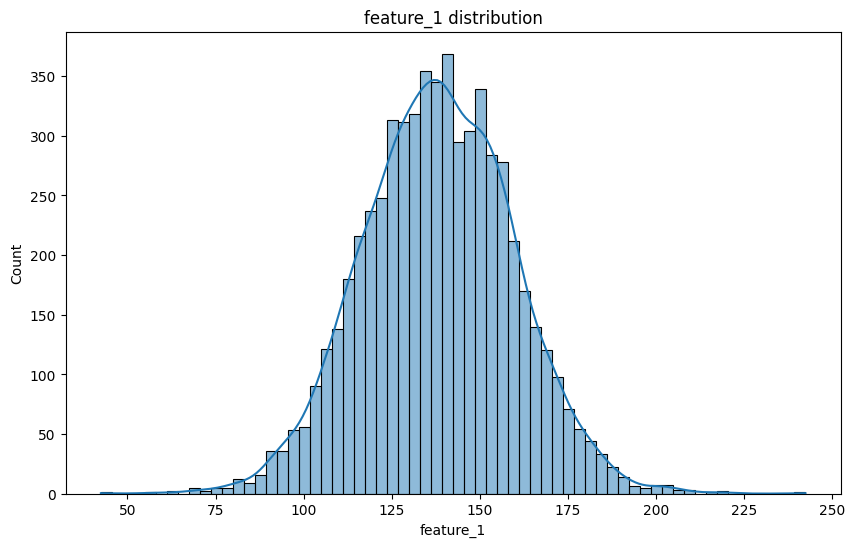

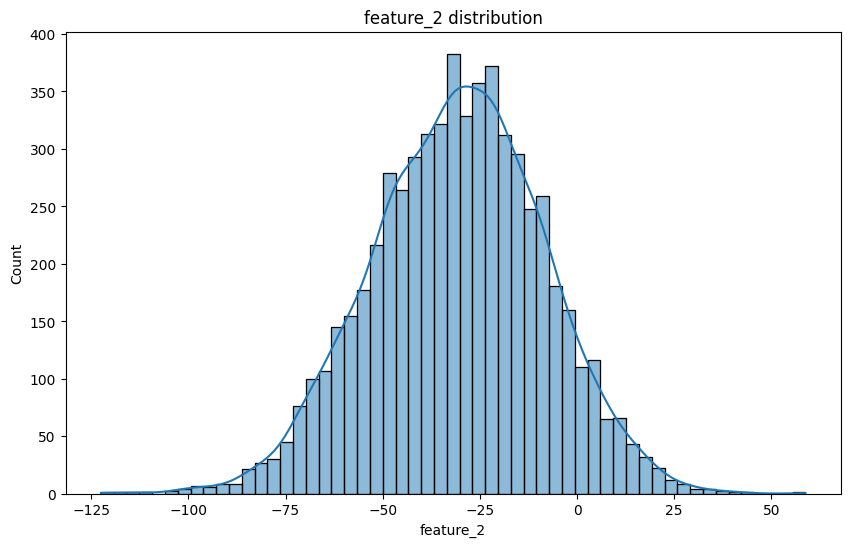

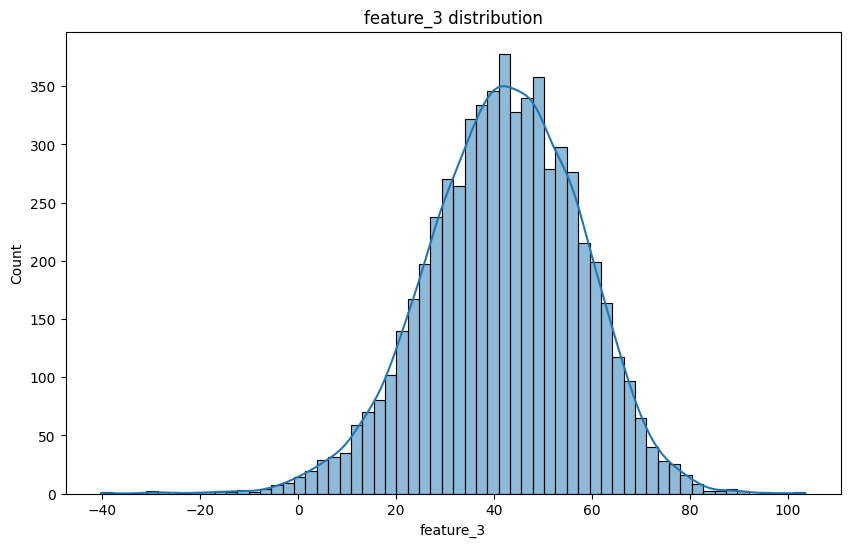

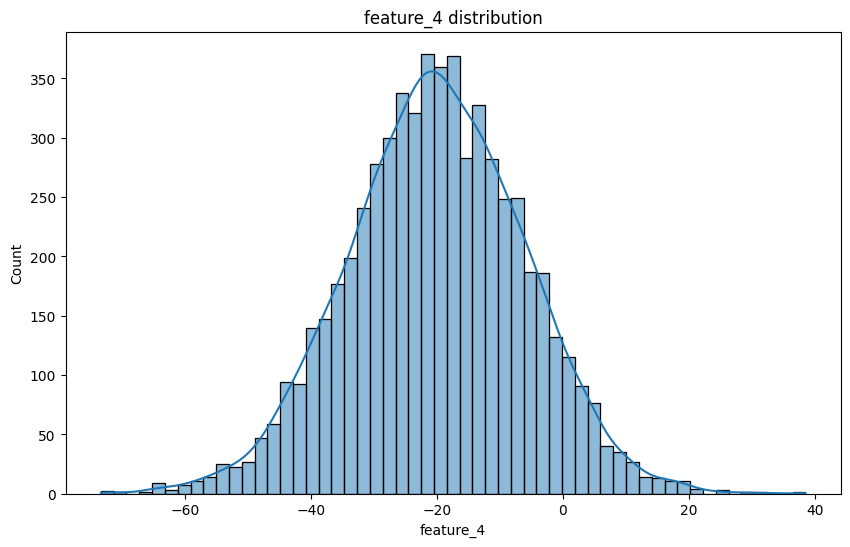

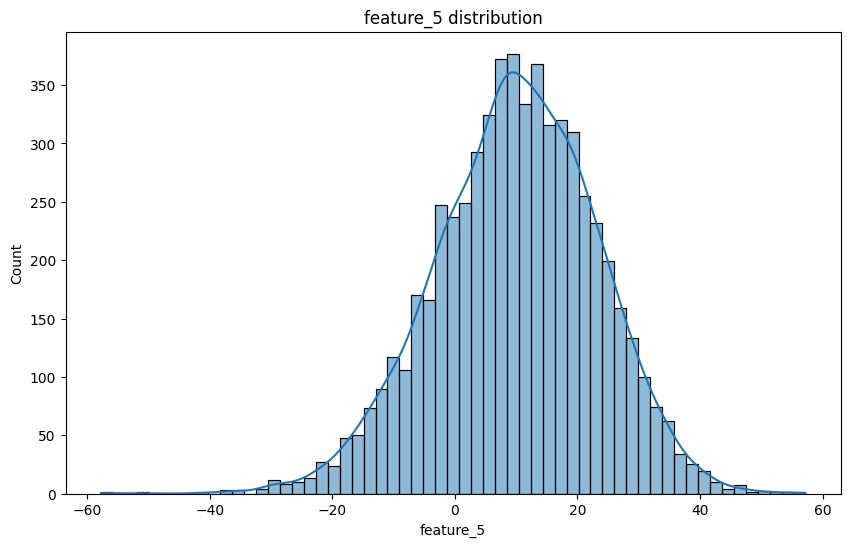

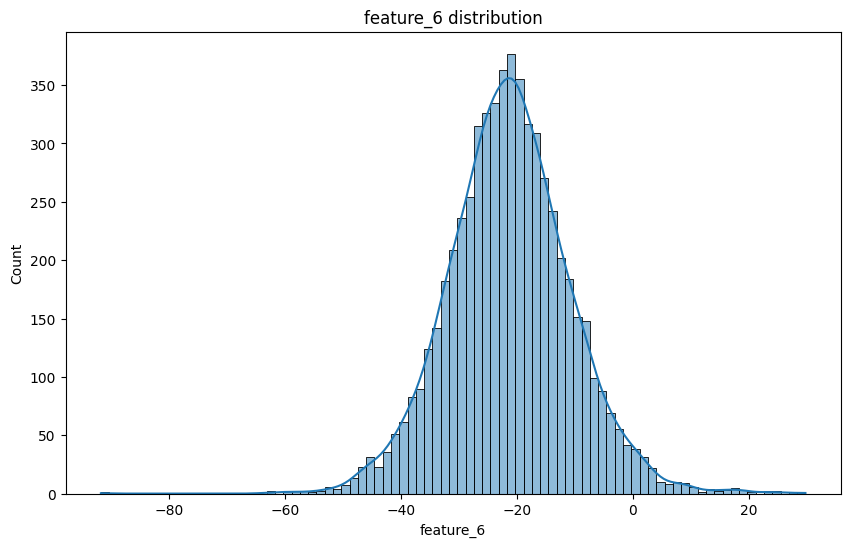

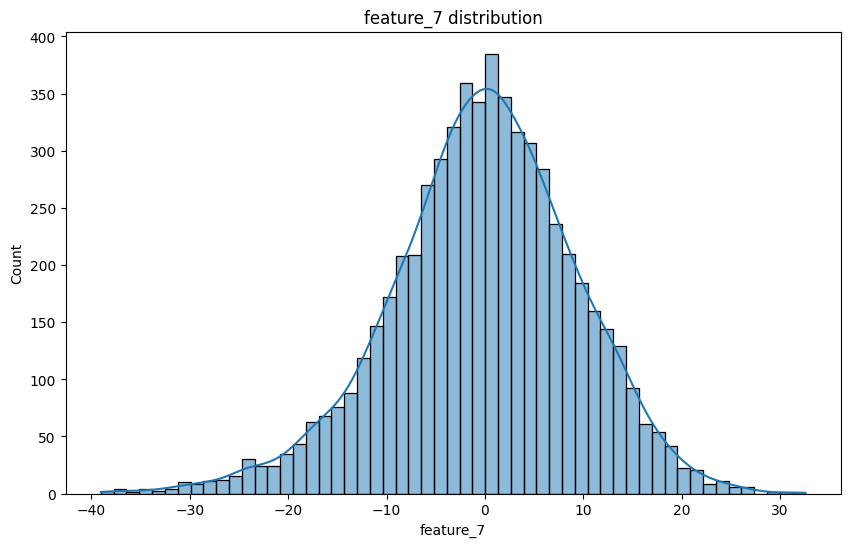

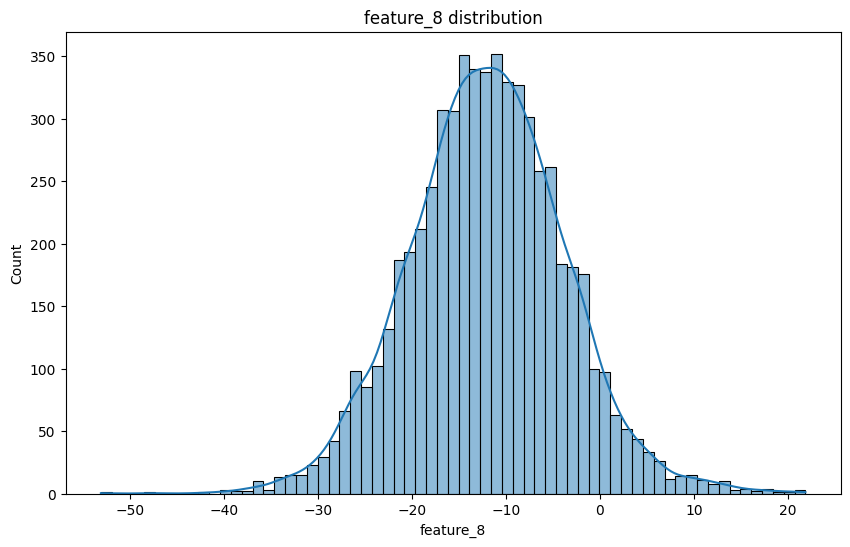

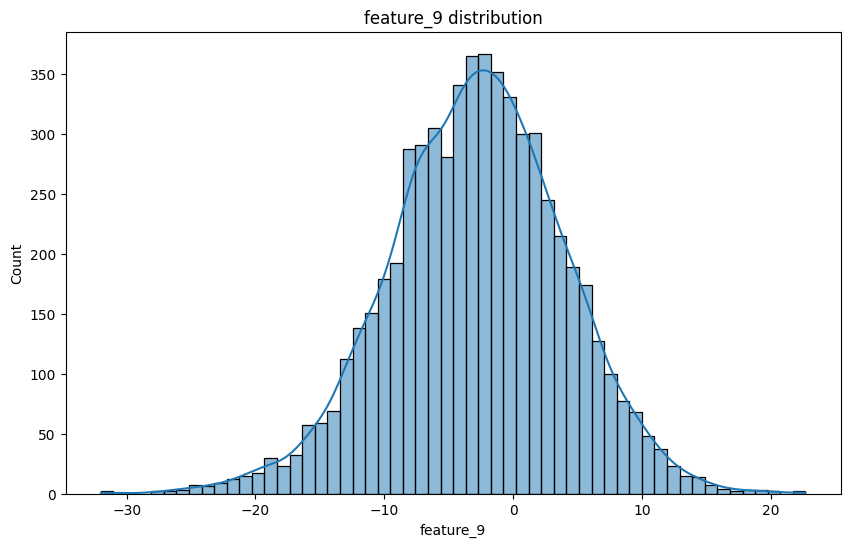

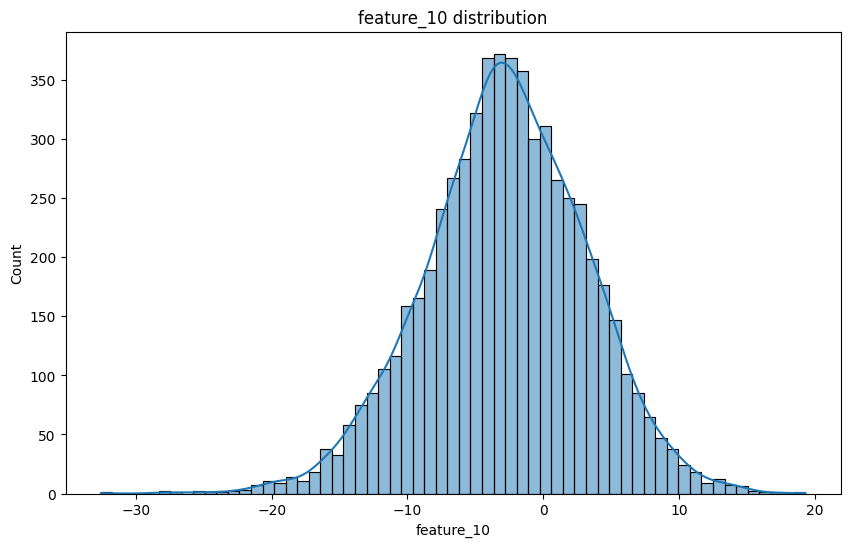

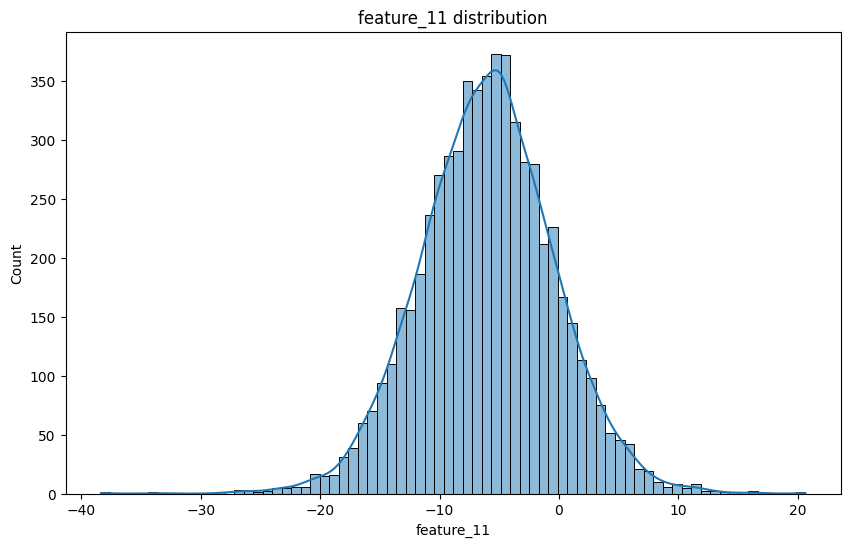

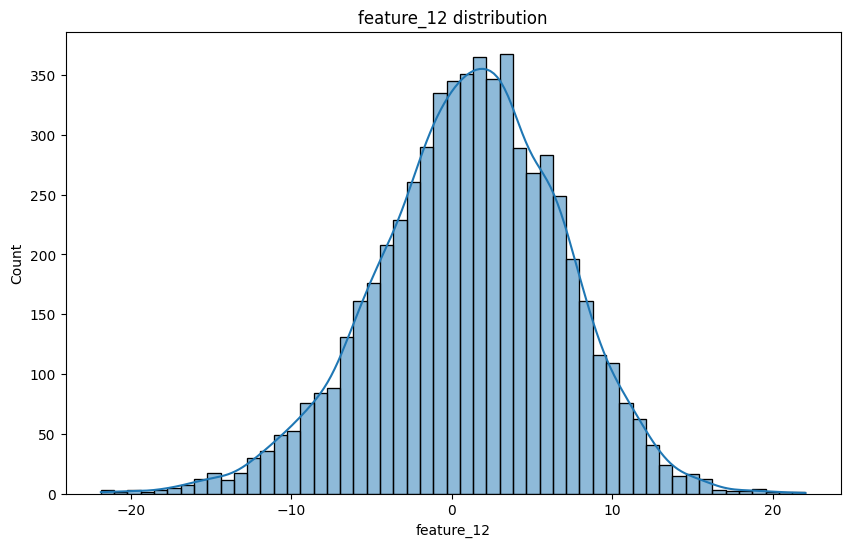

In [28]:
showFeatureDistribution(averageDataset)

Distribution curves look great, let's verify if there is no constant values

In [29]:
def showConstantValues(dataset):
    for feature in dataset.columns[1:]:
        if dataset[feature].nunique() == 1:
            print(f'{feature} is constant')

In [30]:
#Create a dataset with constant values to test our function
constantDataset = pd.DataFrame()
constantDataset['gender'] = [1]*len(averageDataset)
constantDataset['constant2'] = [2]*len(averageDataset)
constantDataset['constant3'] = [3]*len(averageDataset)

showConstantValues(constantDataset)

constant2 is constant
constant3 is constant


In [31]:
showConstantValues(averageDataset)
showConstantValues(shortDataset)
showConstantValues(shortLongDataset)

We have 0 constant values in our datasets. Any NaN ?

In [9]:
#any nan ?
print(any(averageDataset.isnull().sum()))
print(any(shortDataset.isnull().sum()))
print(any(shortLongDataset.isnull().sum()))

False
False
False


We have 0 nulls.

# Model exploration

In [20]:
#imports for the models
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline

In [11]:
#shuffle the dataset
averageDataset = averageDataset.sample(frac=1).reset_index(drop=True)
shortDataset = shortDataset.sample(frac=1).reset_index(drop=True)
shortLongDataset = shortLongDataset.sample(frac=1).reset_index(drop=True)

In [12]:
# Transform gender column: Male -> 0, Female -> 1
datasets = [averageDataset, shortDataset, shortLongDataset]

for dataset in datasets:
    dataset['gender'] = dataset['gender'].map({'males': 0, 'females': 1})

In [13]:
# Split the datasets into features and target
y_average = averageDataset['gender']
X_average = averageDataset.drop(columns="gender") 

y_short = shortDataset['gender']
X_short = shortDataset.drop(columns="gender") 


y_shortLong = averageDataset['gender']
X_shortLong = shortLongDataset.drop(columns="gender") 

"""
y_long = longDataset['gender']
X_long = longDataset.drop(columns="gender") 
"""


'\ny_long = longDataset[\'gender\']\nX_long = longDataset.drop(columns="gender") \n'

In [14]:
# Split the datasets into training and testing sets
X_train_average, X_test_average, y_train_average, y_test_average = train_test_split(X_average, y_average, test_size=0.2, random_state=42)
X_train_short, X_test_short, y_train_short, y_test_short = train_test_split(X_short, y_short, test_size=0.2, random_state=42)
X_train_shortLong, X_test_shortLong, y_train_shortLong, y_test_shortLong = train_test_split(X_shortLong, y_shortLong, test_size=0.2, random_state=42)

Now lets have a quick overview of how differents models defend themselves with the smaller dataset : averageDataset with only 13 features.

In [21]:
pip = make_pipeline(StandardScaler(), LogisticRegression())
start = time()
pip.fit(X_train_average, y_train_average)
end = time()
print(f'Average dataset accuracy (LogisticRegression): {round(pip.score(X_test_average, y_test_average)*100,3)}% in {round(end-start,3)}s')

knn = KNeighborsClassifier()
start = time()
knn.fit(X_train_average, y_train_average)
end = time()
print(f'Average dataset accuracy (KNeighborsClassifier): {round(knn.score(X_test_average, y_test_average)*100,3)}% in {round(end-start,3)}s')

#Classification svr
svc = SVC()
start = time()
svc.fit(X_train_average, y_train_average)
end = time()
print(f'Average dataset accuracy (SVC): {round(svc.score(X_test_average, y_test_average)*100,3)}% in {round(end-start,3)}s')

rf = RandomForestClassifier()
start = time()
rf.fit(X_train_average, y_train_average)
end = time()
print(f'Average dataset accuracy (RandomForestClassifier): {round(rf.score(X_test_average, y_test_average)*100,3)}% in {round(end-start,3)}s')

gb = GradientBoostingClassifier()
start = time()
gb.fit(X_train_average, y_train_average)
end = time()
print(f'ShortLong dataset accuracy (GradientBoostingClassifier): {round(gb.score(X_test_average, y_test_average)*100,3)}% in {round(end-start,3)}s')

Average dataset accuracy (LogisticRegression): 82.652% in 0.008s
Average dataset accuracy (KNeighborsClassifier): 72.227% in 0.008s
Average dataset accuracy (SVC): 80.4% in 0.325s
Average dataset accuracy (RandomForestClassifier): 80.651% in 0.93s
ShortLong dataset accuracy (GradientBoostingClassifier): 82.485% in 1.489s


In [22]:
pip = make_pipeline(StandardScaler(), LogisticRegression())
start = time()
pip.fit(X_train_short, y_train_short)
end = time()
print(f'Short dataset accuracy (LogisticRegression): {round(pip.score(X_test_short, y_test_short)*100,3)}% in {round(end-start,3)}s')

knn = KNeighborsClassifier()
start = time()
knn.fit(X_train_short, y_train_short)
end = time()
print(f'Short dataset accuracy (KNeighborsClassifier): {round(knn.score(X_test_short, y_test_short)*100,3)}% in {round(end-start,3)}s')

svc = SVC()
start = time()
svc.fit(X_train_short, y_train_short)
end = time()
print(f'Short dataset accuracy (SVC): {round(svc.score(X_test_short, y_test_short)*100,3)}% in {round(end-start,3)}s')

rf = RandomForestClassifier()
start = time()
rf.fit(X_train_short, y_train_short)
end = time()
print(f'Short dataset accuracy (RandomForestClassifier): {round(rf.score(X_test_short, y_test_short)*100,3)}% in {round(end-start,3)}s')

gb = GradientBoostingClassifier()
start = time()
gb.fit(X_train_short, y_train_short)
end = time()
print(f'Short dataset accuracy (GradientBoostingClassifier): {round(gb.score(X_test_short, y_test_short)*100,3)}% in {round(end-start,3)}s')

Short dataset accuracy (LogisticRegression): 71.56% in 0.89s
Short dataset accuracy (KNeighborsClassifier): 63.72% in 0.063s
Short dataset accuracy (SVC): 80.651% in 13.627s
Short dataset accuracy (RandomForestClassifier): 79.399% in 17.151s
Short dataset accuracy (GradientBoostingClassifier): 80.4% in 236.87s


Apparently the random forest is capped but not the gradient boosting classifier. This become very computer expensive but lets continue with others dataset. 

In [23]:
pip = make_pipeline(StandardScaler(), LogisticRegression())
start = time()
pip.fit(X_train_shortLong, y_train_shortLong)
end = time()
print(f'ShortLong dataset accuracy (LogisticRegression): {round(pip.score(X_test_shortLong, y_test_shortLong)*100,3)}% in {round(end-start,3)}s')

knn = KNeighborsClassifier()
start = time()
knn.fit(X_train_shortLong, y_train_shortLong)
end = time()
print(f'ShortLong dataset accuracy (KNeighborsClassifier): {round(knn.score(X_test_shortLong, y_test_shortLong)*100,3)}% in {round(end-start,3)}s')

svc = SVC()
start = time()
svc.fit(X_train_shortLong, y_train_shortLong)
end = time()
print(f'ShortLong dataset accuracy (SVC): {round(svc.score(X_test_shortLong, y_test_shortLong)*100,3)}% in {round(end-start,3)}s')

rf = RandomForestClassifier()
start = time()
rf.fit(X_train_shortLong, y_train_shortLong)
end = time()
print(f'ShortLong dataset accuracy (RandomForestClassifier): {round(rf.score(X_test_shortLong, y_test_shortLong)*100,3)}% in {round(end-start,3)}s')

gb = GradientBoostingClassifier()
start = time()
gb.fit(X_train_shortLong, y_train_shortLong)
end = time()
print(f'ShortLong dataset accuracy (GradientBoostingClassifier): {round(gb.score(X_test_shortLong, y_test_shortLong)*100,3)}% in {round(end-start,3)}s')

ShortLong dataset accuracy (LogisticRegression): 52.46% in 1.103s
ShortLong dataset accuracy (KNeighborsClassifier): 56.631% in 0.082s
ShortLong dataset accuracy (SVC): 60.967% in 23.326s
ShortLong dataset accuracy (RandomForestClassifier): 60.133% in 21.63s
ShortLong dataset accuracy (GradientBoostingClassifier): 59.383% in 318.842s
